### CS182 project - Deliver ideas of CGCNN

In [ ]:
### General Explanation

### Embedding Crystal Graph

In [ ]:
# Note: Need pymatgen
# TODO:Explain about Crystal Graph

In [ ]:
!pip install pymatgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 43.1 MB/s eta 0:00:00


In [114]:
import os
import sys
import csv
import json
import torch
import torch.nn as nn
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array

from pymatgen.core.structure import Structure
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import CrystalNN
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from data_utils import CIFData
from data_utils import AtomCustomJSONInitializer
from data_utils import AtomInitializer
from data_utils import GaussianDistance

In [ ]:
!unzip cgcnn_data.zip
!unzip hw_data.zip

In [54]:
# Let's convert salt (NaCl) to crystal graph.
# You can use print method to see the lattice and position of Na, Cl
# Atoms in the cell.
nacl = Structure.from_file('hw_data/sample_regression/1000041.cif')
print(nacl)

Full Formula (Na4 Cl4)
Reduced Formula: NaCl
abc   :   5.620000   5.620000   5.620000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Na+   0    0    0
  1  Na+   0    0.5  0.5
  2  Na+   0.5  0    0.5
  3  Na+   0.5  0.5  0
  4  Cl-   0.5  0.5  0.5
  5  Cl-   0.5  0    0
  6  Cl-   0    0.5  0
  7  Cl-   0    0    0.5


In [ ]:
# add visualization of the structure using the CIF file 

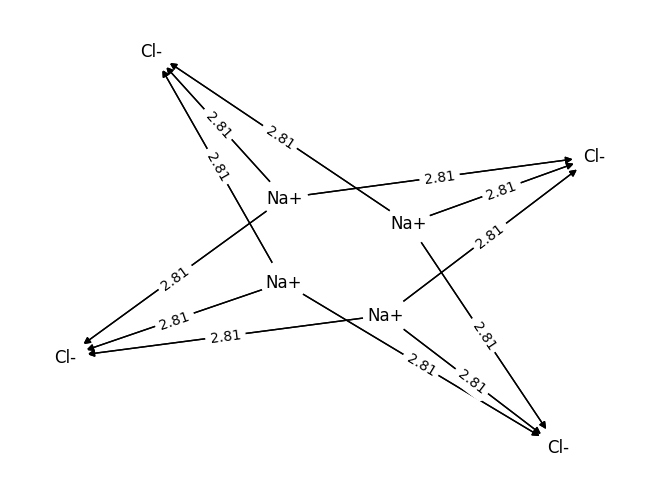

In [98]:

crystal = CrystalNN()

sg = StructureGraph.with_local_env_strategy(nacl, crystal)

node_labels = {}
for i, site in enumerate(nacl):
    label = "{}".format(site.specie)
    node_labels[i] = label

edge_weights = {}
for edge in sg.graph.edges():
    dist = nacl.get_distance(edge[0], edge[1])
    edge_weights[edge] = dist

pos = nx.spring_layout(sg.graph)
nx.draw(sg.graph, pos, with_labels=True, labels=node_labels, font_size=12, node_size=1000, node_color="w")
nx.draw_networkx_edge_labels(sg.graph, pos, edge_labels=edge_weights, font_size=10)
plt.axis("off")
plt.show()

In [99]:
# First we will convert atoms to atomistic features using
# pre-difined atom embedding.
# atom_init.json is containing vector embedding of atoms,
# Where key (1, 2, 3, ..., 100) represent atomic number
# and values are embedding vectors.
# You can try different atom embedding too.

# Load embedding file.
element_embedding_file = 'hw_data/sample_regression/atom_init.json'
with open(element_embedding_file) as f:
    elem_embedding = json.load(f)
elem_embedding = {int(key): value for key, value
                  in elem_embedding.items()}

############################################################################
# TODO: Encode crsytal data to atomistic features.
############################################################################
# Atom_feature shd have shape of (# of atoms, len(embedding vector))

atom_fea = np.vstack([elem_embedding[nacl[i].specie.number]
                      for i in range(len(nacl))])


atom_fea = torch.Tensor(atom_fea)

assert atom_fea.shape == (8,92)

In [100]:
# Next, we will get neighbor information from each atoms in the cell.
# We will get help from pymatgen package.
# get_all_neighbor function of structure object returns atoms within
# the input radius. Note that here len(all_nbrs) is 8 since there are
# 8 atoms (4 Na+, 4 Cl-) in the cell. Each list contain the neighbor
# atom information considering periodicity.
# We will use 12 nearest neighbors after sorting with distance.

all_nbrs = nacl.get_all_neighbors(r = 8, include_index=True)
all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]

assert len(all_nbrs) == 8

nbr_fea_idx, nbr_fea = [], []
for nbr in all_nbrs:
    # Note: x[1] returns distance to neighbors.
    # Note: x[2] returns index of original structure object
    nbr_fea_idx.append(list(map(lambda x: x[2],
                                nbr[:12])))
    nbr_fea.append(list(map(lambda x: x[1],
                            nbr[:12])))

# nbr_fea_idx contain information of nearest neighbor atoms 
# from ith row (ith atom in the cell)
# For example, 0th atom (Na+ (0.0000, 0.0000, 0.0000)) is neighbored
# with 5th, 6th, 7th, etc...
# nbr_fea contain information of nearest neighbot distance. 
nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
nbr_fea_idx = torch.LongTensor(nbr_fea_idx)

nbr_fea_idx_standard = torch.LongTensor([[5, 6, 7, 7, 6, 5, 2, 1, 2, 1, 3, 3],
                                         [4, 7, 6, 7, 6, 4, 2, 0, 3, 2, 3, 3],
                                         [4, 7, 5, 7, 5, 4, 0, 3, 1, 3, 3, 1],
                                         [4, 6, 5, 6, 5, 4, 2, 1, 1, 2, 0, 0],
                                         [3, 1, 2, 3, 2, 1, 6, 5, 6, 5, 7, 7],
                                         [2, 3, 0, 3, 0, 2, 4, 4, 6, 6, 4, 7],
                                         [1, 3, 0, 3, 0, 1, 4, 4, 5, 5, 5, 4],
                                         [2, 1, 0, 2, 1, 0, 4, 5, 5, 4, 6, 6]])

assert torch.equal(nbr_fea_idx, nbr_fea_idx_standard)

AssertionError: ignored

In [101]:
# Now we have two features, atomic feature and neighbor feature.
# Note that neighbor feature is discontionous information with respect to the distanc.
# Therefore we will expand neighbor feature using Gaussian Kernel (or Gaussian filter)
# https://en.wikipedia.org/wiki/Gaussian_filter
dmin = 0
dmax = 12
step = 0.2
var = step
filter_step = np.arange(dmin, dmax+step, step)

def expand(distances):
    ############################################################################
    # TODO: Implement the function.
    ############################################################################
    return np.exp(-(distances[..., np.newaxis] - filter_step)**2 / var**2)

nbr_fea_gaussian = expand(nbr_fea)

In [102]:
assert np.array_equal(nbr_fea_gaussian, nbr_fea)

AssertionError: ignored

In [103]:
gdf = GaussianDistance(dmin=0, dmax=12, step=0.2)
nbr_fea = gdf.expand(nbr_fea)

In [104]:
# Will not be used
data_dir = './cgcnn_data/sample-regression'
test = CIFData(data_dir)
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = test[-1]

In [105]:
# Will not be used
structures, _, _ = test[-1]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

### Build a Model

In [106]:
# TODO: (for the group) Graphics of layers

In [107]:
from model import CrystalGraphConvNet

In [108]:
# Simple test
# Set seed using manual_seed
# TODO explanation about crystal_atom_idx
torch.manual_seed(123)
crystal_atom_idx = [torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7]).long()]
############################################################################
# TODO: Implement the model
############################################################################

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len)

model.forward(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)

tensor([[0.6627]], grad_fn=<AddmmBackward0>)

### Training

In [109]:
from data_utils import collate_pool, get_train_val_test_loader
from train_utils import Normalizer, train, validate, save_checkpoint
from model import CrystalGraphConvNet
from random import sample

In [110]:
torch.manual_seed(123)

# set parameters
data_dir = './hw_data/perovskite_energy'
batch_size = 8
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

# get dataset

dataset = CIFData(data_dir)
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_fn,
    batch_size=batch_size,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    return_test=True)

In [111]:
# normalize target

if len(dataset) < 500:
    warnings.warn('Dataset has less than 500 data points. '
                    'Lower accuracy is expected. ')
    sample_data_list = [dataset[i] for i in range(len(dataset))]
else:
    sample_data_list = [dataset[i] for i in
                        sample(range(len(dataset)), 500)]
_, sample_target, _ = collate_pool(sample_data_list)
normalizer = Normalizer(sample_target)

In [112]:
# build model
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]
############################################################################
# TODO: Tune the following parameters to optimize performance.
############################################################################
# number of hidden atom features in conv layers
atom_fea_len = 64
# number of hidden features after pooling
h_fea_len = 128
# number of conv layers
n_conv = 3
# number of hidden layers after pooling
n_h = 1

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=atom_fea_len,
                            n_conv=n_conv,
                            h_fea_len=h_fea_len,
                            n_h=n_h)

In [115]:
# set hyperparameters
epochs = 15
criterion = nn.MSELoss()
lr = 0.01
momentum = 0.9
weight_decay = 0

optimizer = optim.SGD(model.parameters(), lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

# optimizer = optim.Adam(model.parameters(), lr,
#                         weight_decay=weight_decay)
lr_milestones = [100]
scheduler = MultiStepLR(optimizer, milestones=lr_milestones,
                            gamma=0.1)

In [116]:
for epoch in range(epochs):
    best_mae_error = 1e10
    # train for one epoch
    # TO-Do, add tqdm in the train method, don't print too much here
    # To-Do, fix warning
    train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # evaluate on validation set
    mae_error = validate(val_loader, model, criterion, normalizer)

    if mae_error != mae_error:
        print('Exit due to NaN')
        sys.exit(1)

    scheduler.step()

    # remember the best mae_eror and save checkpoint
    is_best = mae_error < best_mae_error
    best_mae_error = min(mae_error, best_mae_error)

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_mae_error': best_mae_error,
        'optimizer': optimizer.state_dict(),
        'normalizer': normalizer.state_dict(),
    }, is_best)


Epoch: [0][0/67]	Time 0.331 (0.331)	Data 0.153 (0.153)	Loss 0.9089 (0.9089)	MAE 52.953 (52.953)
Epoch: [0][10/67]	Time 0.088 (0.131)	Data 0.007 (0.027)	Loss 0.7308 (2.1911)	MAE 57.486 (88.634)
Epoch: [0][20/67]	Time 0.121 (0.124)	Data 0.010 (0.019)	Loss 0.4646 (1.6788)	MAE 50.236 (74.042)
Epoch: [0][30/67]	Time 0.144 (0.132)	Data 0.047 (0.027)	Loss 0.5162 (1.3818)	MAE 45.077 (66.992)
Epoch: [0][40/67]	Time 0.155 (0.131)	Data 0.025 (0.027)	Loss 2.9797 (1.2818)	MAE 83.490 (62.712)
Epoch: [0][50/67]	Time 0.120 (0.128)	Data 0.006 (0.023)	Loss 0.2951 (1.1158)	MAE 35.339 (58.756)
Epoch: [0][60/67]	Time 0.115 (0.128)	Data 0.006 (0.023)	Loss 1.0737 (1.0636)	MAE 51.202 (56.136)
Test: [0/9]	Time 0.138 (0.138)	Loss 0.2320 (0.2320)	MAE 27.616 (27.616)
 * MAE 40.503
Epoch: [1][0/67]	Time 0.270 (0.270)	Data 0.164 (0.164)	Loss 0.2881 (0.2881)	MAE 36.145 (36.145)
Epoch: [1][10/67]	Time 0.134 (0.178)	Data 0.007 (0.030)	Loss 2.2767 (0.5159)	MAE 58.210 (32.988)
Epoch: [1][20/67]	Time 0.238 (0.198)	Data 0

In [117]:
# test best model
print('---------Evaluate Model on Test Set---------------')
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
validate(test_loader, model, criterion, normalizer, test=True)

---------Evaluate Model on Test Set---------------
Test: [0/9]	Time 0.173 (0.173)	Loss 2.0494 (2.0494)	MAE 66.022 (66.022)
 ** MAE 48.115


tensor(48.1149)

In [ ]:
# hw task, visualize the training loss
